<a id='Title-Variational-Autoencoders'></a>
<h1 style="color:SlateGray;">Variational Autoencoders</h1>

**Input dataset**

MNIST: a set of 28x28 grayscale images of single, handwritten digits.

<h2 style="color:SlateGray;">Background</h2>

**Layers**

[*Dense*](01_Image_Classification.ipynb#Layers-Dense)

[*Conv2D*](06_Basic_ConvNet.ipynb#Layers-Conv2D)

<a id='Layers-Conv2DTranspose'></a>
*Conv2DTranspose*

Upsamples a matrix by reversing the convolution operation.

Reinterprets the convolution operation as a relatively larger-dimensional matrix, thus a transpose of that matrix multiplied with a lower-dimensional matrix will produce a higher-dimensional matrix.

<a id='Layers-Lambda'></a>
*Lambda*

Allows you to create a custom stateless Keras layer that executes an arbitrary expression.

<a id='Layers-Layer'></a>
*Layer*

Allows you to create a custom Keras layer class that will contains states such as weights.

**Activations**

[*relu*](01_Image_Classification.ipynb#Activations-relu)

[*sigmoid*](02_Binary_Classification.ipynb#Activations-sigmoid)
		
**Optimizers**

[*rmsprop*](01_Image_Classification.ipynb#Optimizers-rmsprop)
		
**Loss functions**

[*binary_crossentropy*](02_Binary_Classification.ipynb#Loss-functions-binary_crossentropy)

<h2 style="color:SlateGray;">Overview</h2>

Displays the structured latent space learned by VAE models.

The model takes input samples and learns a latent space from them using convolutional and fully-connected layers. It then takes samples from the normal distribution of that latent space and attempts to reproduce the original image. Loss is computed as combination of the difference between the original and the reproduced image, as well as from the KL divergence, which forces the latent space structure to become more meaningful each iteration.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

In [3]:
from keras.datasets import mnist

(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [4]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
import numpy as np

img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [6]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)

x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)

z_decoded = decoder(z)

In [7]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

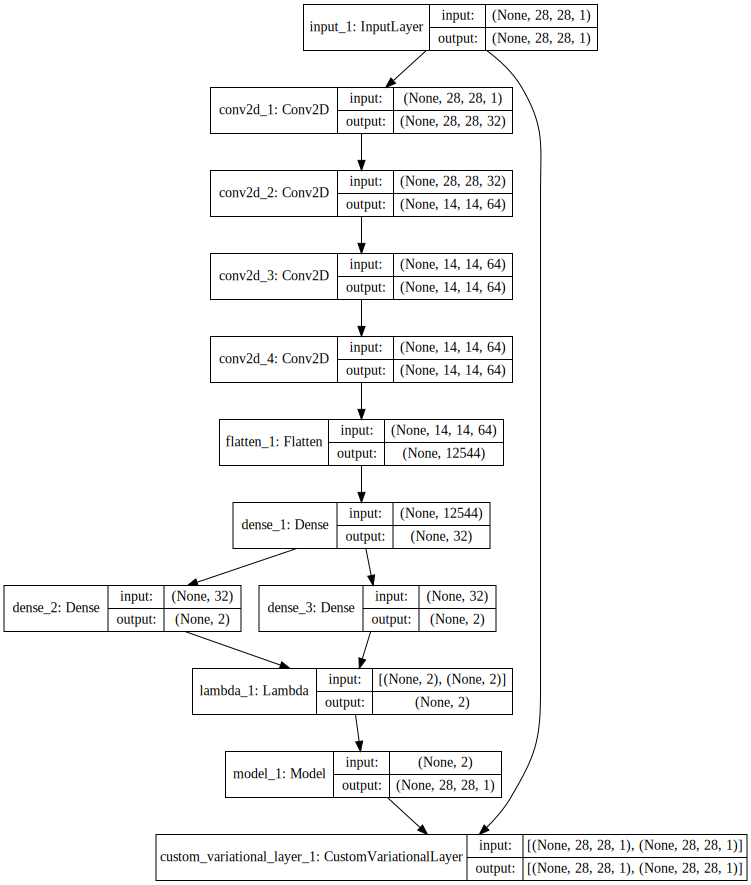

In [8]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(vae, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [9]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 46s 770us/step - loss: 0.2127 - val_loss: 0.1993
Epoch 2/10
60000/60000 [==============================] - 40s 665us/step - loss: 0.1962 - val_loss: 0.1926
Epoch 3/10
60000/60000 [==============================] - 40s 660us/step - loss: 0.1909 - val_loss: 0.1888
Epoch 4/10
60000/60000 [==============================] - 40s 665us/step - loss: 0.1878 - val_loss: 0.1859
Epoch 5/10
60000/60000 [==============================] - 40s 671us/step - loss: 0.1858 - val_loss: 0.1850
Epoch 6/10
60000/60000 [==============================] - 41s 680us/step - loss: 0.1844 - val_loss: 0.1834
Epoch 7/10
60000/60000 [==============================] - 39s 658us/step - loss: 0.1833 - val_loss: 0.1845
Epoch 8/10
60000/60000 [==============================] - 39s 645us/step - loss: 0.1824 - val_loss: 0.1820
Epoch 9/10
60000/60000 [==============================] - 37s 616us/step - loss: 0.1819 - val_

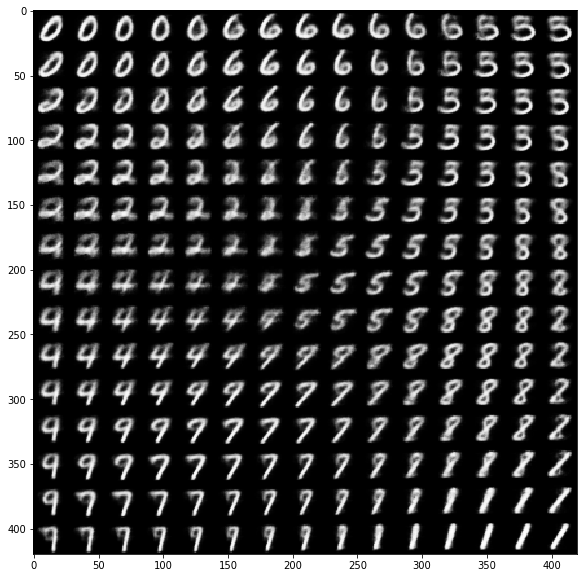

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()